In [351]:
import torch
from torchvision.datasets import MNIST, FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassConfusionMatrix
import pandas as pd

In [352]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [277]:
dataset = FashionMNIST("data", download = True)

100%|█████████████████████████████████████| 26.4M/26.4M [00:04<00:00, 5.65MB/s]
100%|█████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 24.5MB/s]
100%|█████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 3.68MB/s]
100%|█████████████████████████████████████████████| 5.15k/5.15k [00:00<?, ?B/s]


In [353]:
len(dataset), dataset[0][0].size

(60000, (28, 28))

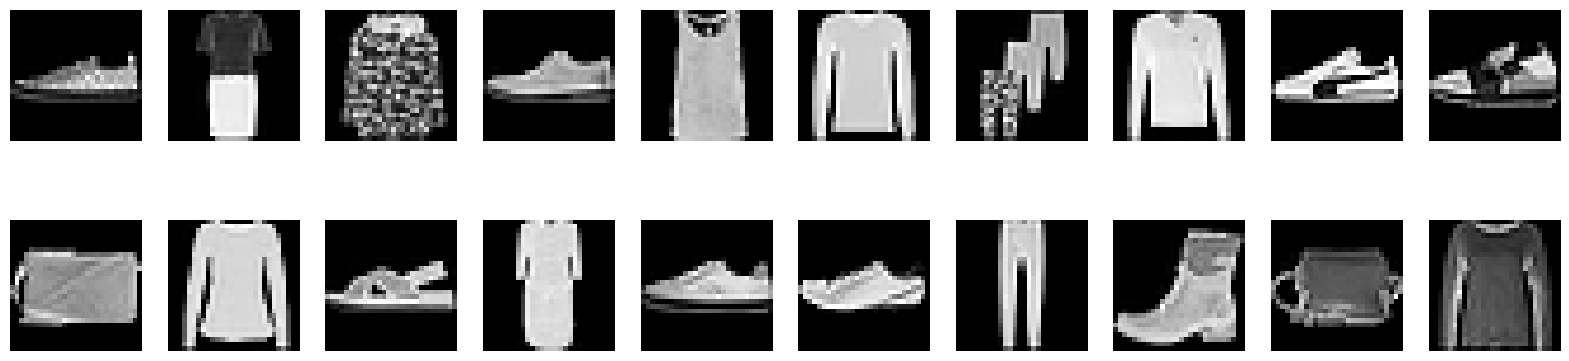

In [354]:
fig, axs = plt.subplots(2,10, figsize = (20,5))
l = np.random.choice(len(dataset), 20, replace = True)
l1 = list(range(20))
for i, j in zip(l,l1):
    axs.flat[j].imshow(dataset[i][0], cmap = "gray")
    axs.flat[j].axis("off")

In [357]:
l_labels = []

for i in range(len(dataset)):
    a =  dataset[i][1]
    if a not in l_labels:
        l_labels.append(a)
        l_labels = sorted(l_labels)
print(len(l_labels))

10


10


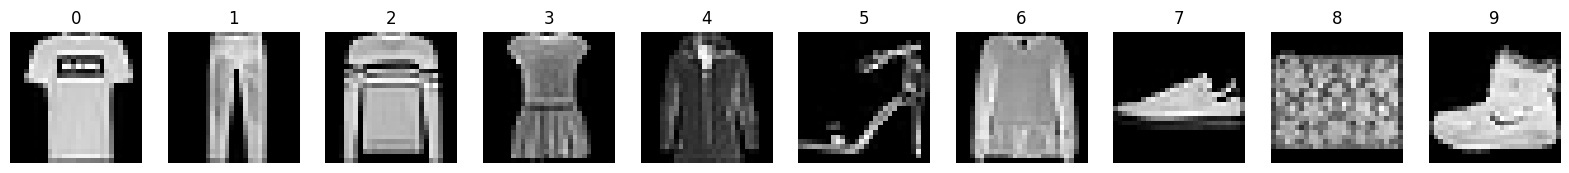

In [358]:
l_images = []
for i in l_labels:
    for j in range(len(dataset)):
        a = dataset[j][1]
        if a==i:
            l_images.append(dataset[j][0])
            break
print(len(l_images))                
fig, axs = plt.subplots(1,10, figsize = (20,5))
for i, image in enumerate(l_images):
    axs.flat[i].imshow(image, cmap = "gray")
    axs.flat[i].axis("off")
    axs.flat[i].set_title(i)

In [359]:
transform = Compose([
    ToTensor(),
    Normalize([0.5],[0.5])])

train_data = FashionMNIST("../../data", download=False, train = True, transform = transform)
test_data = FashionMNIST("../../data", download=False, train = False, transform = transform)

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=1000,  pin_memory=True)

In [360]:
class CNN(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.model = nn.Linear(in_features, n_classes)

    def forward(self, x):

        return self.model(x)
        

In [387]:

test_acc, test_loss, all_matrixs = [], [], []

def train(model, loss_f, optimizer, train_loader, test_loader, n_epoch):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        correct = 0
        for step, (data, target) in enumerate(train_loader):
            data = data.flatten(start_dim =1)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            pred = output.argmax(dim=1, keepdim = True)    
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct/len(train_loader.dataset)
        loss_avg = loss_sum/(step+1)
        print(f"for {epoch} train_accuracy : {acc:.5f}, loss average : {loss_avg:.5f}")

        acc_test, loss_test, matrix = test(model, test_loader, loss_f, n_classes)
        test_acc.append(acc_test)
        test_loss.append(loss_test)
        all_matrixs.append(matrix)
        print( f" test_accuracy {acc_test:.5f}, loss_average {loss_test:.5f}")

def test(model, test_loader, loss_f, n_classes):
    model.eval()
    correct = 0
    loss_sum = 0
    confmat = MulticlassConfusionMatrix(num_classes=n_classes).to(device)
    for step, (data, target) in enumerate(test_loader):
        data = data.flatten(start_dim = 1)
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1)
        confmat.update(pred, target)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc_test = correct/len(test_loader.dataset)
    loss_avg_test = loss_sum/(step+1)
    matrix = confmat.compute()
    return acc_test, loss_avg_test, matrix
    model.train()

In [376]:
model = CNN(28*28, 10)
model = model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)                            
n_epoch = 15
n_classes = 10

In [377]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

In [378]:
train(model,  loss_f, optimizer, train_loader,test_loader, n_epoch)
test(model, test_loader, loss_f, n_classes)

for 0 train_accuracy : 0.68587, loss average : 0.95383
 test_accuracy 0.76920, loss_average 0.66281
for 1 train_accuracy : 0.79835, loss average : 0.59118
 test_accuracy 0.80130, loss_average 0.57372
for 2 train_accuracy : 0.81960, loss average : 0.53050
 test_accuracy 0.81300, loss_average 0.53765
for 3 train_accuracy : 0.83000, loss average : 0.49976
 test_accuracy 0.81940, loss_average 0.52047
for 4 train_accuracy : 0.83450, loss average : 0.48144
 test_accuracy 0.82640, loss_average 0.50344
for 5 train_accuracy : 0.84093, loss average : 0.46700
 test_accuracy 0.83020, loss_average 0.49213
for 6 train_accuracy : 0.84487, loss average : 0.45552
 test_accuracy 0.82700, loss_average 0.48556
for 7 train_accuracy : 0.84697, loss average : 0.44739
 test_accuracy 0.83040, loss_average 0.47952
for 8 train_accuracy : 0.84950, loss average : 0.44074
 test_accuracy 0.83300, loss_average 0.47341
for 9 train_accuracy : 0.85130, loss average : 0.43513
 test_accuracy 0.83400, loss_average 0.46994


(0.8383,
 0.45794699192047117,
 tensor([[846,   2,  16,  42,   3,   5,  72,   0,  14,   0],
         [  5, 951,   5,  28,   6,   0,   3,   0,   2,   0],
         [ 24,   4, 774,  10, 109,   1,  68,   0,  10,   0],
         [ 40,  11,  20, 869,  25,   1,  29,   0,   5,   0],
         [  0,   1, 151,  49, 711,   2,  79,   0,   7,   0],
         [  0,   0,   0,   2,   0, 911,   0,  55,   4,  28],
         [170,   3, 141,  37,  98,   2, 520,   0,  29,   0],
         [  0,   0,   0,   0,   0,  35,   0, 923,   0,  42],
         [  6,   1,  11,  10,   3,   9,  18,   6, 936,   0],
         [  0,   0,   0,   0,   0,  17,   0,  40,   1, 942]], device='cuda:0'))

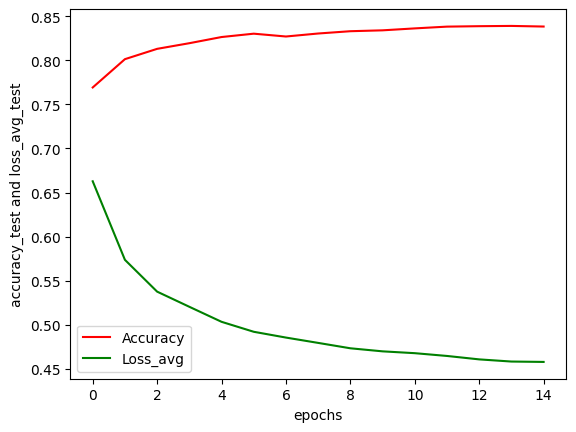

In [380]:
plt.plot(range(n_epoch), test_acc, color = "red", label = "Accuracy")
plt.plot(range(n_epoch), test_loss, color = "green", label = "Loss_avg")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy_test and loss_avg_test")
plt.show();

In [381]:
df_confmat = pd.DataFrame(all_matrixs[-1].tolist(),index = [f"true_{n}" for n in range(10)], columns = [f"pred_{n}" for n in range(10)]).T
df_confmat

,true_0,true_1,true_2,true_3,true_4,true_5,true_6,true_7,true_8,true_9
pred_0,846,5,24,40,0,0,170,0,6,0
pred_1,2,951,4,11,1,0,3,0,1,0
pred_2,16,5,774,20,151,0,141,0,11,0
pred_3,42,28,10,869,49,2,37,0,10,0
pred_4,3,6,109,25,711,0,98,0,3,0
pred_5,5,0,1,1,2,911,2,35,9,17
pred_6,72,3,68,29,79,0,520,0,18,0
pred_7,0,0,0,0,0,55,0,923,6,40
pred_8,14,2,10,5,7,4,29,0,936,1
pred_9,0,0,0,0,0,28,0,42,0,942


In [382]:
max_errors = 0
for column in df_confmat.columns.tolist():
    a = df_confmat[column].sort_values(ascending = False).index[1]
    b = df_confmat[column].sort_values(ascending =False).iloc[1]
    if b > max_errors:
        max_errors = b
        max_column = column
        max_pred = a
        
    print(f" модель чаще всего путала {column} с {a} {b} раз")
print(f" чаще всего модель перепутала {max_column} и {max_pred}  {max_errors} раз")

 модель чаще всего путала true_0 с pred_6 72 раз
 модель чаще всего путала true_1 с pred_3 28 раз
 модель чаще всего путала true_2 с pred_4 109 раз
 модель чаще всего путала true_3 с pred_0 40 раз
 модель чаще всего путала true_4 с pred_2 151 раз
 модель чаще всего путала true_5 с pred_7 55 раз
 модель чаще всего путала true_6 с pred_0 170 раз
 модель чаще всего путала true_7 с pred_9 42 раз
 модель чаще всего путала true_8 с pred_6 18 раз
 модель чаще всего путала true_9 с pred_7 40 раз
 чаще всего модель перепутала true_6 и pred_0  170 раз


In [383]:
#обнулим списки, нужно только опять будет актвивировать ячейку с функциями
del test_acc, test_loss, all_matrixs

In [384]:
class CNN1(nn.Module):
    def __init__(self, in_features, hid_features,hid_features2, n_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hid_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_features, hid_features2)
        self.fc3 = nn.Linear(hid_features2, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x
        

In [385]:
model1 = CNN1(28*28, 128, 128, 10)
model1 = model1.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 1e-3)
n_epoch = 15
n_classes = 10

In [ ]:
summary(model1)

In [388]:
train(model1,  loss_f, optimizer1, train_loader,test_loader, n_epoch)
test(model1, test_loader, loss_f, n_classes)

for 0 train_accuracy : 0.82982, loss average : 0.47501
 test_accuracy 0.83160, loss_average 0.47051
for 1 train_accuracy : 0.84893, loss average : 0.42293
 test_accuracy 0.84490, loss_average 0.43006
for 2 train_accuracy : 0.86158, loss average : 0.38770
 test_accuracy 0.84740, loss_average 0.42034
for 3 train_accuracy : 0.86848, loss average : 0.36703
 test_accuracy 0.85750, loss_average 0.39701
for 4 train_accuracy : 0.87450, loss average : 0.34872
 test_accuracy 0.85590, loss_average 0.39438
for 5 train_accuracy : 0.88012, loss average : 0.33231
 test_accuracy 0.86130, loss_average 0.38279
for 6 train_accuracy : 0.88400, loss average : 0.32060
 test_accuracy 0.86570, loss_average 0.37780
for 7 train_accuracy : 0.88538, loss average : 0.31562
 test_accuracy 0.86940, loss_average 0.36148
for 8 train_accuracy : 0.88997, loss average : 0.30256
 test_accuracy 0.87060, loss_average 0.35939
for 9 train_accuracy : 0.89417, loss average : 0.29015
 test_accuracy 0.86610, loss_average 0.36883


(0.873,
 0.3575673460960388,
 tensor([[847,   3,  15,  15,   1,   0, 107,   1,  11,   0],
         [  3, 967,   3,  20,   2,   1,   3,   0,   1,   0],
         [ 19,   1, 843,  11,  41,   1,  83,   0,   1,   0],
         [ 42,  15,  15, 865,  19,   0,  40,   0,   4,   0],
         [  2,   1, 150,  46, 686,   0, 113,   0,   2,   0],
         [  0,   0,   0,   1,   0, 941,   0,  39,   1,  18],
         [131,   1,  92,  21,  35,   0, 707,   0,  13,   0],
         [  0,   0,   0,   0,   0,  16,   0, 955,   0,  29],
         [  6,   1,   2,   5,   2,   2,   7,   7, 968,   0],
         [  1,   0,   0,   0,   0,   9,   0,  39,   0, 951]], device='cuda:0'))

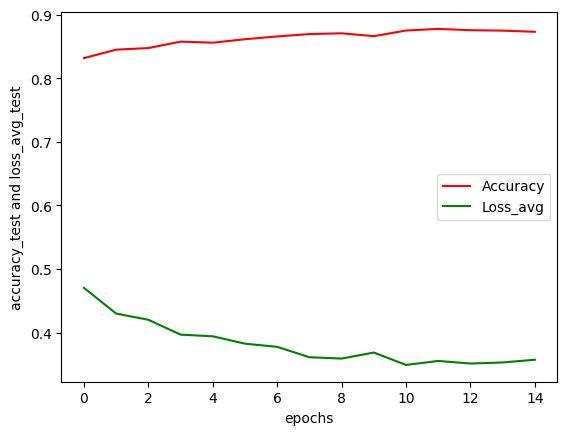

In [389]:
plt.plot(range(n_epoch), test_acc, color = "red", label = "Accuracy")
plt.plot(range(n_epoch), test_loss, color = "green", label = "Loss_avg")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy_test and loss_avg_test")
plt.show();

In [390]:
df_confmat1 = pd.DataFrame(all_matrixs[-1].tolist(),index = [f"true_{n}" for n in range(10)], columns = [f"pred_{n}" for n in range(10)]).T
df_confmat1

,true_0,true_1,true_2,true_3,true_4,true_5,true_6,true_7,true_8,true_9
pred_0,847,3,19,42,2,0,131,0,6,1
pred_1,3,967,1,15,1,0,1,0,1,0
pred_2,15,3,843,15,150,0,92,0,2,0
pred_3,15,20,11,865,46,1,21,0,5,0
pred_4,1,2,41,19,686,0,35,0,2,0
pred_5,0,1,1,0,0,941,0,16,2,9
pred_6,107,3,83,40,113,0,707,0,7,0
pred_7,1,0,0,0,0,39,0,955,7,39
pred_8,11,1,1,4,2,1,13,0,968,0
pred_9,0,0,0,0,0,18,0,29,0,951


In [391]:
max_errors = 0
for column in df_confmat1.columns.tolist():
    a = df_confmat1[column].sort_values(ascending = False).index[1]
    b = df_confmat1[column].sort_values(ascending =False).iloc[1]
    if b > max_errors:
        max_errors = b
        max_column = column
        max_pred = a
        
    print(f" модель чаще всего путала {column} с {a} {b} раз")
print(f" чаще всего модель перепутала {max_column} и {max_pred}  {max_errors} раз")

 модель чаще всего путала true_0 с pred_6 107 раз
 модель чаще всего путала true_1 с pred_3 20 раз
 модель чаще всего путала true_2 с pred_6 83 раз
 модель чаще всего путала true_3 с pred_0 42 раз
 модель чаще всего путала true_4 с pred_2 150 раз
 модель чаще всего путала true_5 с pred_7 39 раз
 модель чаще всего путала true_6 с pred_0 131 раз
 модель чаще всего путала true_7 с pred_9 29 раз
 модель чаще всего путала true_8 с pred_6 7 раз
 модель чаще всего путала true_9 с pred_7 39 раз
 чаще всего модель перепутала true_4 и pred_2  150 раз
